Step 1: Installing libraries...
Libraries imported successfully!
Using device: cpu

--- Step 2: Loading and Preprocessing REAL NSL-KDD Data ---
Dataset Split: Training 8000 | Validation 2000

--- Hybrid Model Defined Successfully ---
Total trainable parameters: 114

--- Starting Semi-Supervised Training ---
Epoch 1/10
train Loss: 0.5431 Acc: 0.5166
val Loss: 0.3811 Acc: 0.8680
--------------------
Epoch 2/10
train Loss: 0.2847 Acc: 0.8994
val Loss: 0.2187 Acc: 0.9285
--------------------
Epoch 3/10
train Loss: 0.1771 Acc: 0.9415
val Loss: 0.1652 Acc: 0.9375
--------------------
Epoch 4/10
train Loss: 0.1417 Acc: 0.9474
val Loss: 0.1459 Acc: 0.9395
--------------------
Epoch 5/10
train Loss: 0.1257 Acc: 0.9493
val Loss: 0.1341 Acc: 0.9420
--------------------
Epoch 6/10
train Loss: 0.1145 Acc: 0.9507
val Loss: 0.1241 Acc: 0.9440
--------------------
Epoch 7/10
train Loss: 0.1064 Acc: 0.9525
val Loss: 0.1180 Acc: 0.9460
--------------------
Epoch 8/10
train Loss: 0.1006 Acc: 0.9530
val L

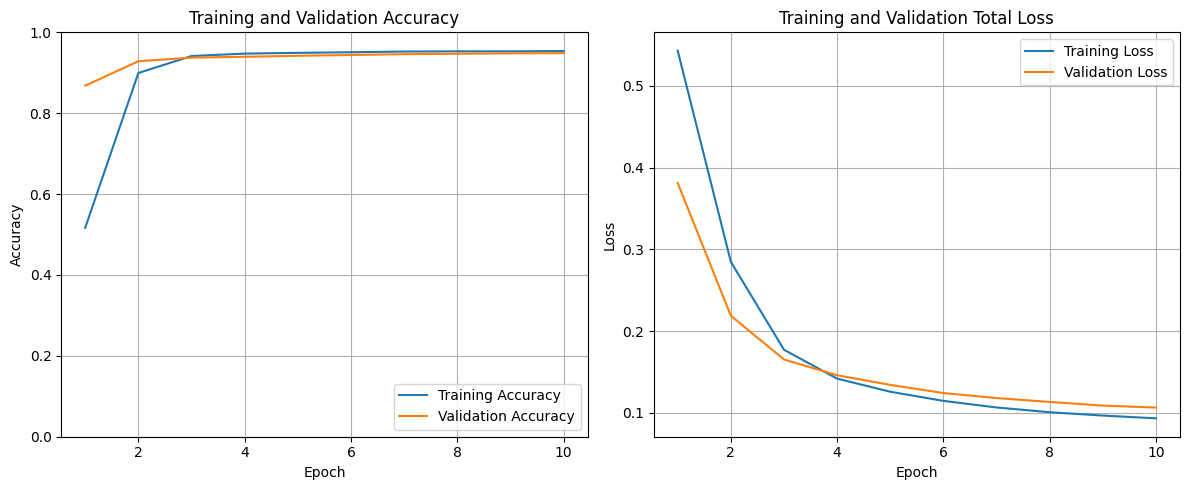


--- Fused Semi-Supervised Project Complete ---


In [ ]:
# --- TELECOM_V2 ---

print("Step 1: Installing libraries...")
!pip install pennylane torchmetrics scikit-learn -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
import pennylane as qml
from pennylane.templates.layers import BasicEntanglerLayers
from pennylane.templates.embeddings import AngleEmbedding

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

print("Libraries imported successfully!")

# --- CONFIGURATION ---
N_QUBITS = 8        # Using 8 qubits/features based on PCA
N_LAYERS = 3        # Number of layers in the QNN
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3
NUM_SAMPLES = 5000  # 5000 normal + 5000 anomaly samples

# --- NEW FUSION CONFIGURATION ---
ALPHA = 0.7  # Weighting factor for Supervised Loss (higher weight for classification)
CENTER_TARGET = 1.0 # Target output for 'Normal' data in the unsupervised boundary loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 2. DATA LOADING & PREPROCESSING (Real NSL-KDD) ---
print("\n--- Step 2: Loading and Preprocessing REAL NSL-KDD Data ---")

# Define the raw column names (same as before)
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

def get_nslkdd_data(num_samples=NUM_SAMPLES, n_pca_features=N_QUBITS):
    try:
        df = pd.read_csv('KDDTrain+.txt', header=None, names=column_names)
    except FileNotFoundError:
        raise FileNotFoundError("KDDTrain+.txt not found. Please upload it to Colab.")

    # Preprocessing
    df['label_binary'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)
    y = df['label_binary'].values

    categorical_cols = ['protocol_type', 'service', 'flag']
    df_features = df.copy()
    for col in categorical_cols:
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col])

    df_features = df_features.drop(columns=['label', 'difficulty', 'label_binary'])
    X = MinMaxScaler().fit_transform(df_features)

    # Balance and PCA
    X_normal = X[y == 0][:num_samples]
    X_anomaly = X[y == 1][:num_samples]
    X_subset = np.concatenate((X_normal, X_anomaly))
    y_subset = np.concatenate((np.zeros(len(X_normal)), np.ones(len(X_anomaly))))

    pca = PCA(n_components=n_pca_features)
    X_pca = pca.fit_transform(X_subset)

    return X_pca, y_subset

# Execute data loading and split
X, y = get_nslkdd_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom PyTorch Dataset Class
class NslKddDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create DataLoaders
train_dataset = NslKddDataset(X_train, y_train)
val_dataset = NslKddDataset(X_val, y_val)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
print(f"Dataset Split: Training {dataset_sizes['train']} | Validation {dataset_sizes['val']}")

# --- 3. HYBRID MODEL DEFINITION (The Stable Architecture) ---

# 3a. Define the Quantum Circuit (QNode)
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def qnn_circuit(inputs, weights):
    AngleEmbedding(inputs, wires=range(N_QUBITS))
    BasicEntanglerLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_LAYERS, N_QUBITS)}

# 3b. Define the Hybrid Model Class
class QuantumTelecomClassifier(nn.Module):
    def __init__(self, qlayer):
        super(QuantumTelecomClassifier, self).__init__()
        self.classical_encoder = nn.Linear(N_QUBITS, N_QUBITS)
        self.qlayer = qlayer
        self.output_layer = nn.Linear(N_QUBITS, 2)

    def forward(self, x):
        x = x.float()
        x = self.classical_encoder(x)
        x = self.qlayer(x)
        x = self.output_layer(x)
        return x

model = QuantumTelecomClassifier(qml.qnn.TorchLayer(qnn_circuit, weight_shapes)).to(device)

print("\n--- Hybrid Model Defined Successfully ---")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_trainable_params}")


# --- 4. DUAL LOSS DEFINITION (The Fusion) ---

# Supervised Loss (CrossEntropy for classification)
criterion_supervised = nn.CrossEntropyLoss()

# Unsupervised Loss (Boundary Loss for Novelty Detection)
def boundary_loss(outputs, labels, center=CENTER_TARGET):
    """Calculates the squared distance of 'Normal' samples from the target center."""
    # The 'Normal' class is index 0
    normal_indices = (labels == 0)
    normal_outputs = outputs[normal_indices, 0]

    # Loss is the mean squared error (MSE) from the target center
    loss = torch.mean((center - normal_outputs)**2)
    return loss

# --- 5. EXECUTE TRAINING AND SHOW RESULTS ---

def train_model(model, optimizer, num_epochs=EPOCHS):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("\n--- Starting Semi-Supervised Training ---")
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    # --- FUSION: Calculate and Combine Losses ---
                    # 1. Supervised Loss
                    supervised_loss = criterion_supervised(outputs, labels)

                    # 2. Unsupervised Boundary Loss
                    unsupervised_loss = boundary_loss(outputs, labels)

                    # 3. Total Loss = Weighted Sum
                    total_loss = (ALPHA * supervised_loss) + ((1 - ALPHA) * unsupervised_loss)

                    if phase == 'train':
                        total_loss.backward() # Backpropagate the combined loss
                        optimizer.step()

                running_loss += total_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history and check for best model (using accuracy)
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print("-" * 20)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# --- 5a. Setup Optimizer ---
params_to_train = [param for param in model.parameters() if param.requires_grad]
optimizer = optim.Adam(params_to_train, lr=LEARNING_RATE)

# --- 5b. Run Training ---
model, history = train_model(model, optimizer)

# --- 5c. Final Evaluation and Plot ---
print("\n--- Final Model Performance (on Validation Set) ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
final_acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"Final Validation Accuracy: {final_acc:.4f}")
print("\nConfusion Matrix (0=Normal, 1=Anomaly):")
print(cm)
print("\nClassification Report:")
print(classification_report(np.array(all_labels), np.array(all_preds), target_names=['Normal (0)', 'Anomaly (1)'], zero_division=0))

# Plot Results
epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig("qnn_fused_results.png")
plt.show()

print("\n--- Fused Semi-Supervised Project Complete ---")

Step 1: Installing libraries...
Libraries imported successfully!
Using device: cpu

--- Step 2: Loading and Preprocessing REAL NSL-KDD Data ---
Dataset Split: Training 8000 | Validation 2000

--- Final Refined Hybrid Model Defined Successfully ---
Total trainable parameters: 162

--- Starting Final Refined Semi-Supervised Training ---
Epoch 1/10
train Loss: 0.5306 Acc: 0.5771
val Loss: 0.3671 Acc: 0.8950
--------------------
Epoch 2/10
train Loss: 0.2971 Acc: 0.9225
val Loss: 0.2399 Acc: 0.9355
--------------------
Epoch 3/10
train Loss: 0.1957 Acc: 0.9451
val Loss: 0.1801 Acc: 0.9340
--------------------
Epoch 4/10
train Loss: 0.1505 Acc: 0.9446
val Loss: 0.1477 Acc: 0.9335
--------------------
Epoch 5/10
train Loss: 0.1252 Acc: 0.9446
val Loss: 0.1312 Acc: 0.9350
--------------------
Epoch 6/10
train Loss: 0.1124 Acc: 0.9457
val Loss: 0.1233 Acc: 0.9365
--------------------
Epoch 7/10
train Loss: 0.1049 Acc: 0.9489
val Loss: 0.1177 Acc: 0.9370
--------------------
Epoch 8/10
train Lo

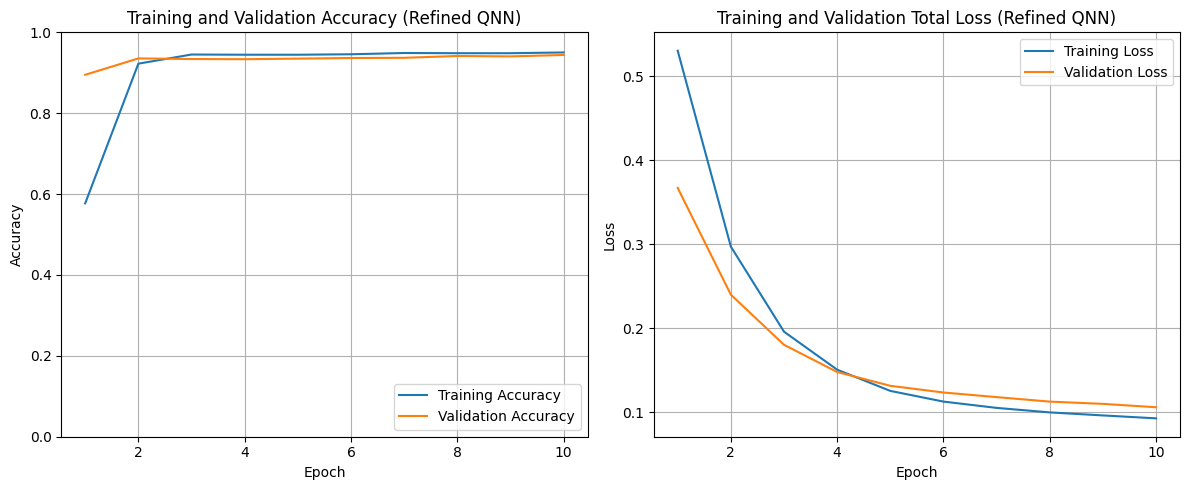


--- Final Refined Fused Semi-Supervised Project Complete ---


In [ ]:
# --- TELECOM_V3a ---


print("Step 1: Installing libraries...")
!pip install pennylane torchmetrics scikit-learn -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
import pennylane as qml
# --- REFINED IMPORTS: Now using the expressive layer ---
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.templates.embeddings import AngleEmbedding

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

print("Libraries imported successfully!")

# --- CONFIGURATION ---
N_QUBITS = 8
N_LAYERS = 3
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3
NUM_SAMPLES = 5000

# --- FUSION CONFIGURATION ---
ALPHA = 0.7
CENTER_TARGET = 1.0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 2. DATA LOADING & PREPROCESSING (Real NSL-KDD) ---
print("\n--- Step 2: Loading and Preprocessing REAL NSL-KDD Data ---")

column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

def get_nslkdd_data(num_samples=NUM_SAMPLES, n_pca_features=N_QUBITS):
    try:
        df = pd.read_csv('KDDTrain+.txt', header=None, names=column_names)
    except FileNotFoundError:
        raise FileNotFoundError("KDDTrain+.txt not found. Please upload it to Colab.")

    df['label_binary'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)
    y = df['label_binary'].values

    categorical_cols = ['protocol_type', 'service', 'flag']
    df_features = df.copy()
    for col in categorical_cols:
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col])

    df_features = df_features.drop(columns=['label', 'difficulty', 'label_binary'])
    X = MinMaxScaler().fit_transform(df_features)

    X_normal = X[y == 0][:num_samples]
    X_anomaly = X[y == 1][:num_samples]
    X_subset = np.concatenate((X_normal, X_anomaly))
    y_subset = np.concatenate((np.zeros(len(X_normal)), np.ones(len(X_anomaly))))

    pca = PCA(n_components=n_pca_features)
    X_pca = pca.fit_transform(X_subset)

    return X_pca, y_subset

X, y = get_nslkdd_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class NslKddDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = NslKddDataset(X_train, y_train)
val_dataset = NslKddDataset(X_val, y_val)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
print(f"Dataset Split: Training {dataset_sizes['train']} | Validation {dataset_sizes['val']}")

# --- 3. HYBRID MODEL DEFINITION (The Stable Architecture) ---

# 3a. Define the Quantum Circuit (QNode)
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def qnn_circuit(inputs, weights):
    AngleEmbedding(inputs, wires=range(N_QUBITS))
    StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

# --- FINAL FIX: Added the third dimension of size 3 ---
weight_shapes = {"weights": (N_LAYERS, N_QUBITS, 3)}

# 3b. Define the Hybrid Model Class
class QuantumTelecomClassifier(nn.Module):
    def __init__(self, qlayer):
        super(QuantumTelecomClassifier, self).__init__()
        self.classical_encoder = nn.Linear(N_QUBITS, N_QUBITS)
        self.qlayer = qlayer
        self.output_layer = nn.Linear(N_QUBITS, 2)

    def forward(self, x):
        x = x.float()
        x = self.classical_encoder(x)
        x = self.qlayer(x)
        x = self.output_layer(x)
        return x

model = QuantumTelecomClassifier(qml.qnn.TorchLayer(qnn_circuit, weight_shapes)).to(device)

print("\n--- Final Refined Hybrid Model Defined Successfully ---")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_trainable_params}")


# --- 4. DUAL LOSS DEFINITION (The Fusion) ---
criterion_supervised = nn.CrossEntropyLoss()

def boundary_loss(outputs, labels, center=CENTER_TARGET):
    normal_indices = (labels == 0)
    normal_outputs = outputs[normal_indices, 0]
    loss = torch.mean((center - normal_outputs)**2)
    return loss

# --- 5. EXECUTE TRAINING AND SHOW RESULTS ---

def train_model(model, optimizer, num_epochs=EPOCHS):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("\n--- Starting Final Refined Semi-Supervised Training ---")
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    supervised_loss = criterion_supervised(outputs, labels)
                    unsupervised_loss = boundary_loss(outputs, labels)
                    total_loss = (ALPHA * supervised_loss) + ((1 - ALPHA) * unsupervised_loss)

                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()

                running_loss += total_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print("-" * 20)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

# --- 5a. Setup Optimizer ---
params_to_train = [param for param in model.parameters() if param.requires_grad]
optimizer = optim.Adam(params_to_train, lr=LEARNING_RATE)

# --- 5b. Run Training ---
model, history = train_model(model, optimizer)

# --- 5c. Final Evaluation and Plot ---
print("\n--- Final Model Performance (on Validation Set) ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"Final Validation Accuracy: {final_acc:.4f}")
print("\nConfusion Matrix (0=Normal, 1=Anomaly):")
print(cm)
print("\nClassification Report:")
print(classification_report(np.array(all_labels), np.array(all_preds), target_names=['Normal (0)', 'Anomaly (1)'], zero_division=0))

epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Refined QNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Total Loss (Refined QNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig("qnn_fused_refined_results.png")
plt.show()

print("\n--- Final Refined Fused Semi-Supervised Project Complete ---")

Step 1: Installing libraries...
Libraries imported successfully!
Using device: cpu

--- Step 2: Loading and Preprocessing FAST, BALANCED Data ---
Dataset Split: Training 8000 | Validation 2000

--- Final Refined Hybrid Model Defined Successfully ---
Applying Identity Initialization to QNN weights...

--- Starting FINAL FAST TRAINING (with BP Mitigation) ---
Epoch 1/10
train Loss: 0.5054 Acc: 0.6699
val Loss: 0.3451 Acc: 0.9220
--------------------
Epoch 2/10
train Loss: 0.2583 Acc: 0.9335
val Loss: 0.2013 Acc: 0.9380
--------------------
Epoch 3/10
train Loss: 0.1696 Acc: 0.9495
val Loss: 0.1566 Acc: 0.9480
--------------------
Epoch 4/10
train Loss: 0.1398 Acc: 0.9536
val Loss: 0.1395 Acc: 0.9520
--------------------
Epoch 5/10
train Loss: 0.1269 Acc: 0.9555
val Loss: 0.1297 Acc: 0.9525
--------------------
Epoch 6/10
train Loss: 0.1194 Acc: 0.9567
val Loss: 0.1235 Acc: 0.9535
--------------------
Epoch 7/10
train Loss: 0.1134 Acc: 0.9574
val Loss: 0.1189 Acc: 0.9535
-----------------

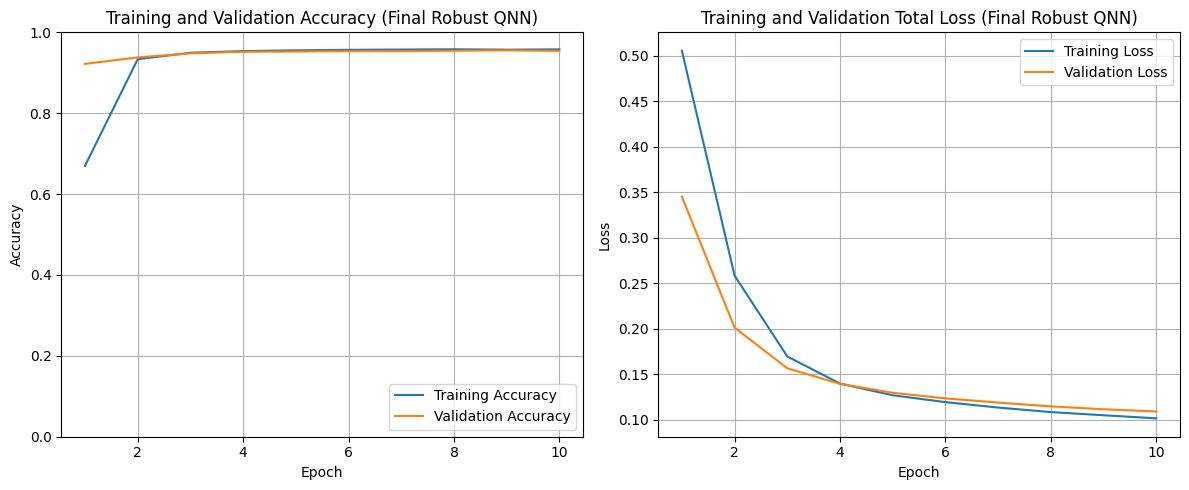


--- Project Final Test Complete ---


In [ ]:
# --- TELECOM_V3b ---


print("Step 1: Installing libraries...")
!pip install pennylane torchmetrics scikit-learn -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
import pennylane as qml
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.templates.embeddings import AngleEmbedding

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

print("Libraries imported successfully!")

# --- CONFIGURATION ---
N_QUBITS = 8
N_LAYERS = 3
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-3
NUM_SAMPLES = 5000 # <-- BACK TO FAST, BALANCED DATA

# --- FUSION CONFIGURATION ---
ALPHA = 0.7
CENTER_TARGET = 1.0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 2. DATA LOADING & PREPROCESSING (Back to Fast, Balanced Data) ---
print("\n--- Step 2: Loading and Preprocessing FAST, BALANCED Data ---")

column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

def get_nslkdd_data(num_samples=NUM_SAMPLES, n_pca_features=N_QUBITS):
    try:
        df = pd.read_csv('KDDTrain+.txt', header=None, names=column_names)
    except FileNotFoundError:
        raise FileNotFoundError("KDDTrain+.txt not found. Please upload it to Colab.")

    df['label_binary'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)
    y = df['label_binary'].values

    categorical_cols = ['protocol_type', 'service', 'flag']
    df_features = df.copy()
    for col in categorical_cols:
        le = LabelEncoder()
        df_features[col] = le.fit_transform(df_features[col])

    df_features = df_features.drop(columns=['label', 'difficulty', 'label_binary'])
    X = MinMaxScaler().fit_transform(df_features)

    # --- Reverting to FAST, BALANCED subset logic ---
    X_normal = X[y == 0][:num_samples]
    X_anomaly = X[y == 1][:num_samples]
    X_subset = np.concatenate((X_normal, X_anomaly))
    y_subset = np.concatenate((np.zeros(len(X_normal)), np.ones(len(X_anomaly))))

    pca = PCA(n_components=n_pca_features)
    X_pca = pca.fit_transform(X_subset)

    return X_pca, y_subset

X, y = get_nslkdd_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class NslKddDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = NslKddDataset(X_train, y_train)
val_dataset = NslKddDataset(X_val, y_val)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
print(f"Dataset Split: Training {dataset_sizes['train']} | Validation {dataset_sizes['val']}")

# --- 3. HYBRID MODEL DEFINITION ---
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def qnn_circuit(inputs, weights):
    AngleEmbedding(inputs, wires=range(N_QUBITS))
    StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_LAYERS, N_QUBITS, 3)}

class QuantumTelecomClassifier(nn.Module):
    def __init__(self, qlayer):
        super(QuantumTelecomClassifier, self).__init__()
        self.classical_encoder = nn.Linear(N_QUBITS, N_QUBITS)
        self.qlayer = qlayer
        self.output_layer = nn.Linear(N_QUBITS, 2)
    def forward(self, x):
        x = x.float()
        x = self.classical_encoder(x)
        x = self.qlayer(x)
        x = self.output_layer(x)
        return x
model = QuantumTelecomClassifier(qml.qnn.TorchLayer(qnn_circuit, weight_shapes)).to(device)
print("\n--- Final Refined Hybrid Model Defined Successfully ---")


# --- BARREN PLATEAU MITIGATION: Identity Initialization ---
def identity_init(model):
    """Initializes the QNN weights to small random values to mitigate barren plateaus."""
    print("Applying Identity Initialization to QNN weights...")
    # Find the QNN layer's weight tensor
    q_layer_weights = model.qlayer.state_dict()['weights']
    # Use uniform initialization with a small range to keep initial gradients from vanishing
    torch.nn.init.uniform_(q_layer_weights, a=-1e-2, b=1e-2)

# --- Apply the Initialization before training ---
identity_init(model)


# --- 4. DUAL LOSS DEFINITION ---
criterion_supervised = nn.CrossEntropyLoss()
def boundary_loss(outputs, labels, center=CENTER_TARGET):
    normal_indices = (labels == 0)
    normal_outputs = outputs[normal_indices, 0]
    loss = torch.mean((center - normal_outputs)**2)
    return loss

# --- 5. EXECUTE TRAINING AND SHOW RESULTS ---
def train_model(model, optimizer, num_epochs=EPOCHS):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print("\n--- Starting FINAL FAST TRAINING (with BP Mitigation) ---")
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    supervised_loss = criterion_supervised(outputs, labels)
                    unsupervised_loss = boundary_loss(outputs, labels)
                    total_loss = (ALPHA * supervised_loss) + ((1 - ALPHA) * unsupervised_loss)
                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()
                running_loss += total_loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
        print("-" * 20)
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, history

params_to_train = [param for param in model.parameters() if param.requires_grad]
optimizer = optim.Adam(params_to_train, lr=LEARNING_RATE)
model, history = train_model(model, optimizer)

print("\n--- Final Model Performance (on Validation Set) ---")
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f"Final Validation Accuracy: {final_acc:.4f}")
print("\nConfusion Matrix (0=Normal, 1=Anomaly):")
print(cm)
print("\nClassification Report:")
print(classification_report(np.array(all_labels), np.array(all_preds), target_names=['Normal (0)', 'Anomaly (1)'], zero_division=0))

epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Final Robust QNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Total Loss (Final Robust QNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.savefig("qnn_final_robust_results.png")
plt.show()

print("\n--- Project Final Test Complete ---")